<img src='data/images/section-notebook-header.png' />

**Important Disclaimer:** This implementation of the Transformer architecture used in this notebook does not support masking, which would be very important in practice. The purpose here is to give a detailed look at the components of a Transformer and how they work together. The implementation is not expected to be used for training real-world models due to missing implementation details as well as lack of performance optimization!

# Transformers

The Transformer is a deep learning architecture that was introduced in the paper ["Attention Is All You Need"](https://arxiv.org/pdf/1706.03762.pdf) by Vaswani et al. in 2017. It was designed for sequence-to-sequence learning tasks, such as machine translation, where the goal is to translate a sequence of words in one language into a sequence of words in another language. The image below is directly taken from the paper, showing the overall model architecture.

<img src="data/images/transformer-architecture.png" />

The Transformer architecture uses self-attention mechanisms to encode the input sequence and generate a sequence of hidden representations, which are then used by the decoder to generate the output sequence. Self-attention mechanisms allow the model to attend to different parts of the input sequence, which helps capture long-range dependencies and generate more accurate context vectors. The Transformer architecture consists of an encoder and a decoder, each of which is composed of a stack of identical layers. The encoder processes the input sequence and generates a sequence of hidden representations, while the decoder generates the output sequence based on the hidden representations and the previously generated output tokens.

Each layer in the Transformer architecture consists of two sub-layers: a multi-head self-attention layer and a position-wise feedforward layer. The self-attention layer allows the model to attend to different parts of the input sequence, while the feedforward layer applies a pointwise feedforward neural network to each position in the sequence independently.

The Transformer architecture has several advantages over traditional recurrent neural networks (RNNs), including the ability to capture long-range dependencies more effectively, the ability to parallelize computation, and the ability to handle variable-length inputs and outputs more easily. As a result, the Transformer has become the architecture of choice for many sequence-to-sequence learning tasks, including machine translation, summarization, and dialogue generation.

## Setting up the Notebook

### Import Required Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.set_printoptions(precision=4, sci_mode=False)

from src.transformer import Attention, AttentionHead, MultiHeadAttention, FeedForward, TransformerEncoderLayer, TransformerEncoder, TransformerDecoderLayer, TransformerDecoder, Transformer, PositionalEncoding

---

## Define Toy Data

### Create Example Batch

Throughout the notebook, we will use a small data batch to run through the transformer components. This toy batch consists of 3 sequences (i.e., batch size is 3) with each sequence of length 6. The values represent word indices which would get after vectorizing our input sentences.

In [3]:
vocab_size = 100
batch_size = 3
seq_len = 6

example_batch = torch.LongTensor(batch_size, seq_len)
example_batch = torch.randint(vocab_size, (batch_size, seq_len))

print(example_batch.shape)

torch.Size([3, 6])


### Embed Example Batch

As usual, we use an `nn.Embedding` layer to transform our word indices into their respective word embedding vector. Again, for the purpose of this notebook, the exact values do not matter since we are not actually training anything. As our largest word index in our example batch is `6`, the input size of the embedding layer can be anything from 7 or higher; here we go with 10.

For the embedding size `embed_size` we use the same value we later chose for the model size of the Transformer architecture. This allows to directly feed the word embeddings into the Transformer. Here, we just set `embed_size = 20` and later `model_size = 20` to make the generated outputs easier to read. The default value proposed in the Transformer paper is `512`.

In [4]:
model_size = 20
embed_size = model_size

embed_layer = nn.Embedding(vocab_size, embed_size)

example_batch_embedded = embed_layer(example_batch)

print(example_batch_embedded.shape)
print()
print(example_batch_embedded[0])

torch.Size([3, 6, 20])

tensor([[ 0.3633,  1.3101,  0.8260, -0.4299, -0.5912,  1.6180,  1.1245,  0.0947,
          0.0549,  0.8453, -2.0232,  0.9273, -0.7709,  0.7598,  1.0286,  0.7037,
          0.8361,  1.0985,  1.5895,  0.3183],
        [-0.9060, -0.5960,  0.2608,  1.6971, -0.2437, -0.2800, -1.2402, -0.2349,
          0.1719,  1.1286, -1.9683,  0.7064,  1.6782, -0.0339,  0.0792, -0.7646,
          0.8880,  1.3979, -0.2184,  0.3823],
        [-2.5377, -0.6504, -0.4188,  0.1694, -0.6836,  0.1483,  0.2924, -1.2261,
         -1.1034, -0.4428,  0.4511,  0.1552,  0.5720,  1.0915, -1.4115, -1.0533,
          0.8683, -0.2274, -0.9201, -3.0720],
        [-2.2708, -0.5484, -0.7336, -0.2563, -0.6865,  1.3768, -1.9041,  1.4967,
         -0.9106,  1.0137,  0.0875,  1.0944, -0.6291, -0.0381,  1.6945,  0.0628,
          1.4151, -1.3120, -0.2120, -0.7100],
        [ 0.1619,  0.8324,  0.8990, -2.1527, -0.1512,  0.9651, -0.0472,  1.2516,
         -0.7131, -0.0040,  1.0020, -1.6650,  1.2651,  0.7111, 

---

## Transformer Components

### Scaled Dot Product Attention

The Scaled Dot Product Attention mechanism is used to selectively focus on certain parts of an input sequence, based on the relevance of each part to a given task. It works by computing a set of weights that represent the importance of each input element, and then using these weights to combine the input elements into a weighted sum.

More specifically, given a set of input vectors (or embeddings) Q, K, and V, where Q represents the query, K represents the keys, and V represents the values, the scaled dot product attention mechanism computes the attention scores between each query vector and key vector using dot product, scales them by the square root of the dimensionality of the key vectors, and applies the softmax function to obtain the attention weights. Finally, it computes a weighted sum of the value vectors using the attention weights.

Mathematically, the scaled dot product attention can be represented as:

$$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

where $d_k$ is the dimensionality of the key vectors. From an architectural point of view, the figure below visualizes this computation (taken from Transformer paper):

<img src="data/images/transformer-attention.png" />

The class `Attention` in `src.transformer.py` implements the Scaled Dot Product attention; apart from the masking.

In [5]:
attention = Attention()

print(attention)

Attention()


The `Attention` class does not define any modules/layers, but only performs computations. Hence the print statement is "empty".

We can run the attention mechanism using our embedded example batch. In the code cell below, `Q`, `K` and `V` are the same; more specifically: `example_batch_embedded` This is an example of **self-attention** which is used in both the encoder and decoder of the transformer.

Self-attention is a mechanism to enable the model to focus on the most relevant parts of the input data when making predictions or generating output. In the context of NLP, self-attention is a type of attention mechanism where the attention weights are calculated based on the similarity between each word in a sequence and all other words in the same sequence. The self-attention mechanism allows the model to weigh the importance of each word in the sequence based on its context and relevance to the overall meaning of the input sequence.

In [6]:
attn_out = attention(example_batch_embedded, example_batch_embedded, example_batch_embedded)

print(attn_out.shape)
print()
print(attn_out[0])

torch.Size([3, 6, 20])

tensor([[ 0.2973,  1.2107,  0.7588, -0.3949, -0.5870,  1.5476,  1.0049,  0.1136,
          0.0601,  0.8330, -1.9446,  0.9095, -0.6859,  0.7289,  0.9845,  0.6310,
          0.8495,  1.0312,  1.5004,  0.2698],
        [-0.9093, -0.5375,  0.1852,  1.4548, -0.2951, -0.1491, -1.1224, -0.1793,
          0.1378,  1.0359, -1.7778,  0.7043,  1.4774,  0.0366,  0.0975, -0.7096,
          0.9143,  1.1840, -0.1531,  0.2107],
        [-2.4640, -0.6207, -0.3976,  0.1263, -0.6723,  0.1746,  0.2540, -1.1412,
         -1.0771, -0.4100,  0.4421,  0.1375,  0.5768,  1.0649, -1.3508, -1.0313,
          0.8576, -0.2167, -0.9100, -3.0047],
        [-2.2257, -0.5359, -0.7097, -0.2439, -0.6812,  1.3374, -1.8338,  1.4260,
         -0.8856,  0.9818,  0.0675,  1.0645, -0.5790, -0.0110,  1.6105,  0.0345,
          1.3939, -1.2531, -0.2108, -0.7379],
        [ 0.0528,  0.7677,  0.8371, -2.0452, -0.1758,  0.9354, -0.0442,  1.1563,
         -0.7190, -0.0105,  0.9618, -1.5691,  1.2248,  0.7192, 

The shape of the output `attn_out` is the same as the shape of `example_batch_embedded` since the attention mechanism only returns a re-weighted instance of the input, with the weights being the calculated attention weights. You can see the change by comparing the output of `attn_out[0]` with the output of `example_batch_embedded[0]` above. They are different.

### Multi-Head Attention

In the multi-head attention mechanism, the input vectors are first linearly projected into multiple, lower-dimensional subspaces, and then each attention head operates on one of these subspaces in parallel, learning different representations and different attention distributions. The output of each attention head is then concatenated and linearly projected to produce the final output.

#### Attention Head

An attention head is a single self-attention mechanism that computes the attention scores between a set of input vectors (or embeddings) Q, K, and V. Each attention head operates on a different representation of the input sequence, learned during the model training.

The class `AttentionHead` in `src.transformer.py` implements an individual Attention Head. As input parameter it gets both the `model_size` as well as `qkv_size` which specifies the sizes of the vectors in Q, K, and V for the Scaled Dot Product Attention. In principle, `qkv_size` can be any value here, but later we see how the Transformer papers computes `qkv_size` based on the `model_size`.

In [7]:
qkv_size = 5

attention_head = AttentionHead(model_size, qkv_size)

print(attention_head)

AttentionHead(
  (Wq): Linear(in_features=20, out_features=5, bias=True)
  (Wk): Linear(in_features=20, out_features=5, bias=True)
  (Wv): Linear(in_features=20, out_features=5, bias=True)
  (attention): Attention()
)


Again, let's run an attention head over our embedded example batch.

In [8]:
attention_head_out = attention_head(example_batch_embedded, example_batch_embedded, example_batch_embedded)

print(attention_head_out.shape)

torch.Size([3, 6, 5])


Note that the size of each word vector is now `5`, instead of `20`, reflecting the value of `qkv_size`. Of course, we want the final vector size to be again 20 (i.e., the `model_size`). This is done as part of Multi-Head Attention.

#### Multi-Head Attention

The purpose of using multiple attention heads is to allow the model to attend to different aspects of the input sequence at different positions and abstraction levels, which can lead to improved performance in various natural language processing tasks, such as machine translation, language modeling, and sentiment analysis.

<img src="data/images/transformer-mha-02.png" />

The class `MultiHeadAttention` in `src.transformer.py` implements an Multi-Head Attention. Again, here, we keep its definition very flexible, allowing basically arbitrary values for `num_heads` and `qkv_size`. However, with `num_heads = 4` we already pick a value that will later match the choice of `qkv_size`: `qkv_size = model_size // num_heads`. For our concrete example: `5 = 20 // 4`.

In [9]:
num_heads = 4

mha = MultiHeadAttention(model_size, num_heads)

print(mha)

MultiHeadAttention(
  (heads): ModuleList(
    (0-3): 4 x AttentionHead(
      (Wq): Linear(in_features=20, out_features=5, bias=True)
      (Wk): Linear(in_features=20, out_features=5, bias=True)
      (Wv): Linear(in_features=20, out_features=5, bias=True)
      (attention): Attention()
    )
  )
  (Wo): Linear(in_features=20, out_features=20, bias=True)
)


In the output above, you can clearly identify the 4 Attention Heads. You can also see `qkv_size = model_size // num_heads` -- and assuming the math works out nicely -- the concatenation of the outputs of all heads would already give the right size of `model_size`. However, to be more flexible as well as having more trainable parameters, the Multi-Head Attention uses a `nn.Linear` at the end to ensure the output to be of size `model_size`.

Let's apply Multi-Head Attention on our example batch.

In [10]:
mha_out = mha(example_batch_embedded, example_batch_embedded, example_batch_embedded)

print(mha_out.shape)

torch.Size([3, 6, 20])


Now the output shape is again the same as the input shape.

### Feed Forward Layer

The feedforward layer is another important component in the Transformer architecture, along with the multi-head self-attention layer. The feedforward layer is a fully connected neural network layer that is applied to each position in the input sequence independently.

The feedforward layer consists of two linear transformations with a ReLU activation function in between. The first linear transformation projects the input vector to a higher-dimensional space, and the second linear transformation maps it back to the original dimensionality. The output of the feedforward layer is computed as follows:

$$FFN(x) = max(0, xW_1 + b_1)W_2 + b_2$$

where $x$ is the input vector, $W_1$ and $W_2$ are learnable weight matrices, $b_1$ and $b_2$ are learnable bias vectors, and $max(0, \cdot)$ represents the ReLU activation function.

The feedforward layer serves as a non-linear transformation that allows the model to learn complex relationships between the input tokens. It is applied to each position in the input sequence independently, which enables the model to capture positional information in the sequence. In the Transformer architecture, the feedforward layer is typically applied after the self-attention layer, and the output of the feedforward layer is used as input to the next layer in the model.

The class `FeedForward` in `src.transformer.py` implements the Feed Forward Layer. It uses the exact same architecture as proposed in the Transformer paper, but you can easily see that there is not principle limit w.r.t. the number of sizes of the `nn.Linear` layers.

In [11]:
ff = FeedForward(20)

print(ff)

FeedForward(
  (net): Sequential(
    (0): Linear(in_features=20, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=20, bias=True)
  )
)


The code cell below feeds the output of the Multi-Head Attention layers into the Feed Forward Layers. We could also use `example_batch_embedded` here since the shapes are the same, in the Transformer architecture, the Feed Forward  Layer gets the MHA output as input.

In [12]:
ff_out = ff(mha_out)

print(ff_out.shape)

torch.Size([3, 6, 20])


Of course, the output shape is still the same.

### Encoder

The purpose of the encoder in the Transformer architecture is to process the input sequence and generate a sequence of hidden representations that capture the meaning of the input. This sequence of hidden representations can then be used by the decoder to generate the output sequence.

The purpose of the encoder is to generate a sequence of hidden representations that capture the meaning of the input sequence in a way that is useful for the decoder to generate the output sequence. This sequence of hidden representations is produced by stacking multiple encoder layers, each of which successively refines the representation of the input sequence by attending to different parts of the sequence and incorporating context from previous layers.

The encoded sequence of hidden representations can then be used by the decoder to generate the output sequence, with the attention mechanism used to weight the different hidden representations and incorporate relevant information from the input sequence into the output sequence.

#### Encoder Layer

A single encoder layer in the Transformer architecture takes an input sequence of embeddings and applies the following operations sequentially:

* **Multi-Head Self-Attention Mechanism:** This sub-layer computes the self-attention of the input sequence using multiple attention heads, which enables the model to attend to different parts of the input sequence simultaneously. The self-attention mechanism generates a weighted sum of the input sequence, where the weights are computed based on the similarity between each input element and every other element in the sequence.

* **Feedforward Neural Network:** This sub-layer applies a pointwise feedforward neural network to each position in the input sequence independently. It consists of two linear transformations with a ReLU activation function in between, which allows the model to learn non-linear relationships between the input tokens.

After these two sub-layers are applied, a residual connection and layer normalization are performed on the output of the sub-layers. The residual connection allows the gradient to flow more easily through the network during training, and the layer normalization ensures that the activations of the network are not sensitive to the scale of the inputs. The output of the single encoder layer is then passed to the next encoder layer in the stack. The number of encoder layers can be adjusted to control the capacity and complexity of the model, depending on the requirements of the task at hand.

The class `TransformerEncoderLayer` in `src.transformer.py` implements a single Encoder Layer combining the Multi-Head Attention and Feed Forward Layer. Note that `qkv_size` is not an input parameter here since `TransformerEncoderLayer` computes the `qkv_size` in the `__init__()` method based on the values for `model_size` and `num_heads`.

In [13]:
ff_hidden_size, dropout = 2048, 0.2

transformer_encoder_layer = TransformerEncoderLayer(model_size, num_heads, ff_hidden_size, dropout)

print(transformer_encoder_layer)

TransformerEncoderLayer(
  (mha1): MultiHeadAttention(
    (heads): ModuleList(
      (0-3): 4 x AttentionHead(
        (Wq): Linear(in_features=20, out_features=5, bias=True)
        (Wk): Linear(in_features=20, out_features=5, bias=True)
        (Wv): Linear(in_features=20, out_features=5, bias=True)
        (attention): Attention()
      )
    )
    (Wo): Linear(in_features=20, out_features=20, bias=True)
  )
  (dropout1): Dropout(p=0.2, inplace=False)
  (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
  (ff): FeedForward(
    (net): Sequential(
      (0): Linear(in_features=20, out_features=2048, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2048, out_features=20, bias=True)
    )
  )
  (dropout2): Dropout(p=0.2, inplace=False)
  (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
)


Let's push our example batch through a single Encoder Layer.

In [14]:
transformer_encoder_layer_out = transformer_encoder_layer(example_batch_embedded)

print(transformer_encoder_layer_out.shape)

torch.Size([3, 6, 20])


In this case, it's actually important that the input shape and out shape are the same as this will allow us to stack multiple Encoder layers on top of each other to form the complete Encoder.

#### Complete Encoder

The Transformer encoder has multiple layers for several reasons:

* **Hierarchical Feature Extraction:** Each layer in the Transformer encoder extracts features from the output of the previous layer. The first layer extracts basic features from the input sequence, while subsequent layers extract increasingly complex and abstract features. This hierarchical feature extraction allows the model to capture information at multiple levels of abstraction, which can be important for many natural language processing tasks.

* **Increased Capacity:** By adding more layers, the capacity of the model can be increased, allowing it to learn more complex patterns in the data. This is particularly important for large-scale tasks, such as machine translation and language modeling, where the input sequences can be very long and the complexity of the task requires a larger model.

* **Stability and Robustness:** Multiple layers can help stabilize the training process by making it less sensitive to initialization and optimizing the gradient flow through the network. By passing the output of each layer through a residual connection, the model can learn to incrementally improve its predictions, making it more robust to noise in the input data.

* **Improved Generalization:** By using multiple layers, the model can learn to generalize better to new data. Each layer learns a different representation of the input sequence, and by combining the outputs of all the layers, the model can learn a more robust and generalizable representation of the input.

In summary, the use of multiple layers in the Transformer encoder enables the model to capture information at multiple levels of abstraction, increases its capacity, improves its stability and robustness during training, and helps it generalize better to new data.

The class `TransformerEncoder` in `src.transformer.py` implements the complete Transformer Encoder. This class is essentially just a wrapper for the `num_layers` Encoder layers.

In [15]:
num_layers = 6

transformer_encoder = TransformerEncoder(num_layers=num_layers, model_size=model_size, num_heads=num_heads, ff_hidden_size=ff_hidden_size, dropout= dropout)

print(transformer_encoder)

TransformerEncoder(
  (layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (mha1): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x AttentionHead(
            (Wq): Linear(in_features=20, out_features=5, bias=True)
            (Wk): Linear(in_features=20, out_features=5, bias=True)
            (Wv): Linear(in_features=20, out_features=5, bias=True)
            (attention): Attention()
          )
        )
        (Wo): Linear(in_features=20, out_features=20, bias=True)
      )
      (dropout1): Dropout(p=0.2, inplace=False)
      (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=20, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=20, bias=True)
        )
      )
      (dropout2): Dropout(p=0.2, inplace=False)
      (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    )
  )
)


Now we have everything place to push our example batch through the Encoder part of the Transformer architecture.

In [16]:
transformer_encoder_out = transformer_encoder(example_batch_embedded)

print(transformer_encoder_out.shape)

torch.Size([3, 6, 20])


### Decoder

The decoder in the Transformer architecture is responsible for generating the output sequence, given the encoded input sequence. The purpose of the decoder is to attend to the input sequence and use it to generate a context vector, which is then used to generate the output sequence.

The decoder achieves this by using a multi-layer stack of decoder layers. Each decoder layer in the stack receives as input the output of the previous decoder layer and the encoded input sequence. The first decoder layer receives as input a special start-of-sequence token, which serves as the initial input for the decoding process.

At each layer, the decoder uses a combination of self-attention and multi-head attention mechanisms to attend to different parts of the input sequence and generate a context vector. The decoder then uses the context vector to generate the output sequence using a feedforward neural network.

The decoder is used in various natural language processing tasks such as language translation and language generation, where the model is required to produce an output sequence based on an input sequence. In machine translation, for example, the input sequence is a sentence in one language, and the output sequence is the corresponding sentence in another language. In language generation, the input sequence could be a prompt, and the output sequence could be a continuation of the prompt to generate a coherent paragraph.


#### Decoder Layer

In the Transformer architecture, a single decoder layer takes as input the output of the previous decoder layer and the output of the final encoder layer. The decoder layer consists of three sub-layers:

* **Masked Multi-Head Self-Attention:** This sub-layer performs a multi-head self-attention operation on the output of the previous decoder layer, with a mask to prevent attending to future positions. This allows the decoder to attend to the input sequence in a causal manner, i.e., only using information from previous positions in the output sequence.

* **Multi-Head Attention over Encoder Outputs:** This sub-layer performs a multi-head attention operation over the output of the final encoder layer, with queries from the output of the masked multi-head self-attention sub-layer. This enables the decoder to attend to different parts of the input sequence and incorporate relevant information from the input sequence into the output sequence.

* **Feedforward Neural Network:** This sub-layer applies a pointwise feedforward neural network to each position in the output sequence independently, similarly to the feedforward layer in the encoder. This sub-layer allows the decoder to learn complex relationships between the output tokens and produce more complex output sequences.

After these sub-layers are applied, a residual connection and layer normalization are performed on the output of the sub-layers. The residual connection allows the gradient to flow more easily through the network during training, and the layer normalization ensures that the activations of the network are not sensitive to the scale of the inputs. The output of the single decoder layer is then passed to the next decoder layer in the stack. The number of decoder layers can be adjusted to control the capacity and complexity of the model, depending on the requirements of the task at hand.

The class `TransformerDecoderLayer` in `src.transformer.py` implements an individual Decoder Layer. It is very similar to the Encoder Layer except that the Decoder Layer has a Multi-Head Attention block: one for the self attention of the decoder input, and one for source-target attention for relating the encoder output with the decoder input.

In [17]:
transformer_decoder_layer = TransformerDecoderLayer(model_size, num_heads, ff_hidden_size, dropout)

print(transformer_decoder_layer)

TransformerDecoderLayer(
  (mha1): MultiHeadAttention(
    (heads): ModuleList(
      (0-3): 4 x AttentionHead(
        (Wq): Linear(in_features=20, out_features=5, bias=True)
        (Wk): Linear(in_features=20, out_features=5, bias=True)
        (Wv): Linear(in_features=20, out_features=5, bias=True)
        (attention): Attention()
      )
    )
    (Wo): Linear(in_features=20, out_features=20, bias=True)
  )
  (dropout1): Dropout(p=0.2, inplace=False)
  (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
  (mha2): MultiHeadAttention(
    (heads): ModuleList(
      (0-3): 4 x AttentionHead(
        (Wq): Linear(in_features=20, out_features=5, bias=True)
        (Wk): Linear(in_features=20, out_features=5, bias=True)
        (Wv): Linear(in_features=20, out_features=5, bias=True)
        (attention): Attention()
      )
    )
    (Wo): Linear(in_features=20, out_features=20, bias=True)
  )
  (dropout2): Dropout(p=0.2, inplace=False)
  (norm2): LayerNorm((20,), eps=1e-05, el

In [18]:
transformer_decoder_layer_out = transformer_decoder_layer(example_batch_embedded, example_batch_embedded)

print(transformer_decoder_layer_out.shape)

torch.Size([3, 6, 20])


#### Complete Decoder

The Transformer decoder has multiple layers for the same reason as the encoder: to enable the model to capture increasingly complex dependencies and generate more accurate and fluent output sequences. Each decoder layer in the stack processes the output of the previous decoder layer, along with the encoded input sequence. By stacking multiple decoder layers, the model can learn to attend to different parts of the input sequence and generate increasingly accurate context vectors for generating the output sequence.

In addition, using multiple decoder layers allows the model to learn a hierarchy of representations, where each layer learns to focus on different aspects of the input sequence and capture different levels of abstraction. The lower layers may learn to capture more local dependencies in the input sequence, while the higher layers may learn to capture more global dependencies and abstract concepts. Furthermore, using multiple decoder layers also allows the model to benefit from residual connections and layer normalization, which help stabilize the training of deep neural networks by allowing gradients to flow more easily through the network.

The class `TransformerDecoder` in `src.transformer.py` implements complete Decoder; analogous to the `TransformerEncoder`.

In [19]:
transformer_decoder = TransformerDecoder(num_layers=num_layers, model_size=model_size, num_heads=num_heads, ff_hidden_size=ff_hidden_size, dropout=dropout)

print(transformer_decoder)

TransformerDecoder(
  (layers): ModuleList(
    (0-5): 6 x TransformerDecoderLayer(
      (mha1): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x AttentionHead(
            (Wq): Linear(in_features=20, out_features=5, bias=True)
            (Wk): Linear(in_features=20, out_features=5, bias=True)
            (Wv): Linear(in_features=20, out_features=5, bias=True)
            (attention): Attention()
          )
        )
        (Wo): Linear(in_features=20, out_features=20, bias=True)
      )
      (dropout1): Dropout(p=0.2, inplace=False)
      (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (mha2): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x AttentionHead(
            (Wq): Linear(in_features=20, out_features=5, bias=True)
            (Wk): Linear(in_features=20, out_features=5, bias=True)
            (Wv): Linear(in_features=20, out_features=5, bias=True)
            (attention): Attention()
          )
        )
   

In [20]:
transformer_decoder_out = transformer_decoder(example_batch_embedded, example_batch_embedded)

print(transformer_decoder_out.shape)

torch.Size([3, 6, 20])


---

## Transformer (Complete Encoder-Decoder Architecture)

Now that we have the complete Encoder and Decoder, we can combine them into the Transformer Encoder-Decoder architecture. The class `Transformer` in `src.transformer.py` implements this final architecture. Note that this simple implementation assumes that the number of attention heads, the hidden size of the Feed Forward Layers, as well as the Dropout layers are the same for the Encoder and Decoder are the same; only the number of layers may differ between the Encoder and Decoder. Of course, we could have used more input parameters to allow, for example, for the Encoder and Decoder to have different numbers of heads.

In [21]:
transformer = Transformer(num_encoder_layers=num_layers, 
                          num_decoder_layers=num_layers, 
                          model_size=model_size, 
                          num_heads=num_heads, 
                          ff_hidden_size=ff_hidden_size, 
                          dropout=dropout)

print(transformer)

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (mha1): MultiHeadAttention(
          (heads): ModuleList(
            (0-3): 4 x AttentionHead(
              (Wq): Linear(in_features=20, out_features=5, bias=True)
              (Wk): Linear(in_features=20, out_features=5, bias=True)
              (Wv): Linear(in_features=20, out_features=5, bias=True)
              (attention): Attention()
            )
          )
          (Wo): Linear(in_features=20, out_features=20, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (ff): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=20, out_features=2048, bias=True)
            (1): ReLU()
            (2): Linear(in_features=2048, out_features=20, bias=True)
          )
        )
        (dropout2): Dropout(p=0.2, inplace=False)
        (norm2): 

What you should have observed from the print statements for each module/layer by now is that the overall architecture of the transformer has become quite complex. We can even quantify this by computing the total number of trainable parameters. For this, we can use the following function and apply it on our `transformer` instance.

In [22]:
def get_number_of_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
get_number_of_trainable_parameters(transformer)

1039296

As you can see, even with a small model size of `20`, the complete Encoder-Decoder architecture already has over 1 Million trainable parameters. With the default model size of `512`, this number jumps to over 44 Million trainable parameters -- assuming the same number of Encoder/Decoder layers, number of Attention Heads, and hidden sizes for the Feed Forward Layers.

Now one last time, let's push our example batch through the whole architecture.

In [23]:
transformer_out = transformer(example_batch_embedded, example_batch_embedded)

print(transformer_out.shape)

torch.Size([3, 6, 20])


---

## Positional Encoding

Positional encoding is a technique used in the Transformer architecture to incorporate information about the position of tokens in a sequence. Since the Transformer architecture doesn't use recurrent connections like traditional sequence models, it needs a way to convey the order of the tokens in the sequence to the model. Positional encoding adds a set of fixed vectors to the input embeddings that represent the position of each token in the sequence. These vectors are added to the input embeddings before they are fed into the Transformer encoder, and are learned during training.

The positional encoding vectors have a specific pattern that allows the Transformer to distinguish between tokens based on their position in the sequence. Specifically, the vectors are sinusoidal functions of different frequencies and phases that repeat over the sequence length. The purpose of positional encoding is to give the Transformer architecture a way to capture the order of tokens in a sequence without using recurrent connections. By encoding the position of each token as a fixed vector, the Transformer can distinguish between tokens based on their position in the sequence and capture long-range dependencies more effectively.

The class `PositionalEncoding` in `src.transformer.py` implements Positional Encoding. This code is directly taken from a PyTorch tutorial. Note that this implementation takes a batch of word embeddings as input and adds the positional encodings. To see the individual positional encodings the `forward()` method also returns them individually. You should also appreciate that all positional encodings are precomputed in the `__init__()` method since those encoding are always the same. So there is no need to always compute them on the fly in the `forward()` method. In the `forward()` method, we only access the precomputed positional encodings.

In [24]:
positional_encoding = PositionalEncoding(model_size)

print(positional_encoding)

PositionalEncoding(
  (dropout): Dropout(p=0.1, inplace=False)
)


Let's have a look at the positional encoding for our example batch.

In [25]:
_, example_batch_pos_encoded = positional_encoding(example_batch_embedded)

print(example_batch_pos_encoded.shape)
print()
print(example_batch_pos_encoded)

torch.Size([1, 6, 20])

tensor([[[     0.0000,      1.0000,      0.0000,      1.0000,      0.0000,
               1.0000,      0.0000,      1.0000,      0.0000,      1.0000,
               0.0000,      1.0000,      0.0000,      1.0000,      0.0000,
               1.0000,      0.0000,      1.0000,      0.0000,      1.0000],
         [     0.8415,      0.5403,      0.3877,      0.9218,      0.1578,
               0.9875,      0.0631,      0.9980,      0.0251,      0.9997,
               0.0100,      0.9999,      0.0040,      1.0000,      0.0016,
               1.0000,      0.0006,      1.0000,      0.0003,      1.0000],
         [     0.9093,     -0.4161,      0.7147,      0.6994,      0.3117,
               0.9502,      0.1259,      0.9920,      0.0502,      0.9987,
               0.0200,      0.9998,      0.0080,      1.0000,      0.0032,
               1.0000,      0.0013,      1.0000,      0.0005,      1.0000],
         [     0.1411,     -0.9900,      0.9300,      0.3676,      0.4578

Note the shape of `[1, 6, 20]` since the positional encodings are of course the same for all sequences in the batch. For example, the positional encoding for the 4th word in all sequences in the batch is exactly the same vector.

We can also visualize the positional encodings. Since our example batch is a bit too small for this, let's first create a random batch of shape `(batch_size, seq_len, model_size)` where `model_size` again represents the size of the word embeddings.

In [26]:
batch_size, seq_len = 1, 50

random_batch_embedded = rand_tensor = torch.rand((batch_size, seq_len, model_size))

For this random batch, we can again compute all positional encodings as before.

In [27]:
_, random_batch_pos_encoded = positional_encoding(random_batch_embedded)

print(random_batch_pos_encoded.squeeze(0).shape)

torch.Size([50, 20])


We can now plot the positional encodings by means of a heatmap where the color represents the values in the encoding vectors.

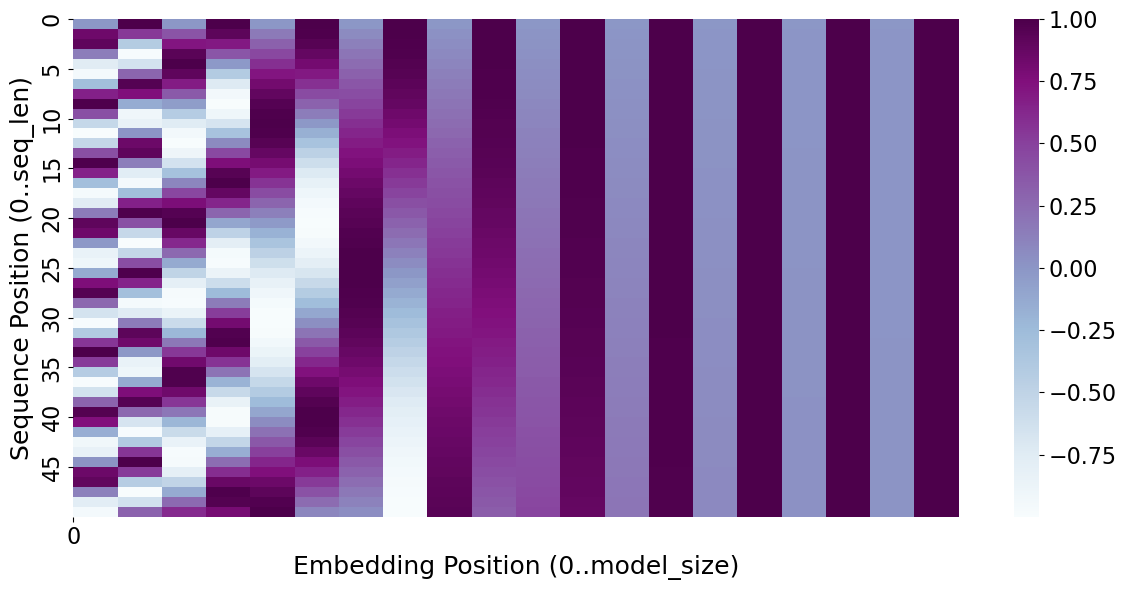

In [28]:
fig = plt.figure(figsize=(12,6))
r = sns.heatmap(random_batch_pos_encoded.squeeze(0), cmap='BuPu')
plt.xticks(range(0, model_size, 25), range(0, model_size, 25))
plt.yticks(range(0, seq_len, 5), range(0, seq_len, 5))
# Change the fontsize of minor ticks label 
plt.gca().tick_params(axis='both', which='major', labelsize=16)
plt.gca().tick_params(axis='both', which='minor', labelsize=8)
cbar = r.collections[0].colorbar
# Set the label size to 20
cbar.ax.tick_params(labelsize=16)
plt.xlabel("Embedding Position (0..model_size)", fontsize=18)
plt.ylabel("Sequence Position (0..seq_len)", fontsize=18)
plt.tight_layout()
plt.show()

In the plot above, each row represents a positional encoding at the respective position. For example, the first row represents the positional encoding of the first position (index 0). We can see from the colors, this encoding is the vector `[0 1 0 1 0 ...]` which matches the output of the encoding tensor above. This computation of the positional encoding meets our 3 requirements

* **Uniqueness:** All positional encodings (i.e., all rows) are unique

* **Scale:** All values in the encodings are in the range [-1, 1]

* **Input-Independence:** the values in the encodings do not depend on the input (i.e., the length of the input sequences)

## Summary

The Transformer architecture is a deep learning model that revolutionized the field of natural language processing (NLP) and machine translation. It was introduced by Vaswani et al. in 2017 and has since become the foundation for many state-of-the-art NLP models. The key idea behind the Transformer is its ability to capture long-range dependencies in sequences using self-attention mechanisms.

Unlike traditional recurrent neural networks (RNNs) or convolutional neural networks (CNNs), the Transformer does not rely on sequential processing or fixed-size convolutional filters. Instead, it employs a self-attention mechanism that allows it to weigh the importance of different words in a sentence when encoding or decoding information. Self-attention enables the model to capture relationships between words that are far apart, making it particularly effective for tasks involving long sequences.

The architecture of the Transformer consists of an encoder and a decoder, both composed of multiple identical layers. Each layer contains a multi-head self-attention mechanism and position-wise feed-forward neural networks. During the encoding phase, the self-attention mechanism in the encoder allows the model to attend to all words in the input sequence simultaneously, capturing their contextual information. In the decoding phase, the self-attention mechanism in the decoder additionally attends to the previously generated output tokens, enabling the model to generate accurate and coherent translations.

The Transformer architecture has demonstrated remarkable performance in various NLP tasks, such as machine translation, text summarization, question answering, and sentiment analysis. It has significantly outperformed previous approaches and has become the de facto standard in NLP research. The ability of Transformers to capture long-range dependencies and model context effectively has led to significant advancements in the field and continues to drive progress in natural language understanding and generation.